### LSTM BackSlices model

In [25]:
## output file suffix
suffix = 'common_rnn'

In [26]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report
from sklearn import metrics, tree
from sklearn import preprocessing, ensemble

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, SimpleRNN, GRU, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

In [29]:
import seaborn
%pylab inline
matplotlib.rc('font', family='Arial')

Populating the interactive namespace from numpy and matplotlib


In [30]:
def metrics_vs_threshold(model, X, y, legend_loc):
    threshold = []
    precision = []
    recall = []
    f1_score = []
    for th in range(0, 10):
        th = th/10.

        threshold.append(th)
        prediction = model.predict(X)[:,1]
        
        precision.append(metrics.precision_score(y, prediction>=th))
        recall.append(metrics.recall_score(y, prediction>=th))
        # f1_score.append(metrics.f1_score(y, prediction_probability[:,1]>=th))
        
        
    pylab.grid(True)
    if precision[9]==0:
        pylab.plot(threshold[:9], precision[:9], 'g-', marker='o', label='precision')
        # pylab.plot(threshold[:9], f1_score[:9], 'b-', marker='o', label='f1 score')    
    else:
        pylab.plot(threshold, precision, 'g-', marker='o', label='precision')
        # pylab.plot(threshold, f1_score, 'b-', marker='o', label='f1 score') 
    pylab.plot(threshold, recall, 'r-', marker='o', label='recall')
    
    pylab.ylim((0, 1.05))
    pylab.title('Metrics vs Threshold')
    pylab.legend(loc=legend_loc)
    
    # print 'f1_score max:', max(f1_score), 'threshold:', threshold[argmax(f1_score)]

### Load the data

In [31]:
data = pd.read_csv('data/Transform_data.csv', sep=';', 
                   parse_dates=['DateofTermination', 'Timeline'], decimal=".")

In [32]:
data.shape

(156243, 157)

#### Missing values check

In [33]:
for col in data.columns:
    if sum(data[col].isnull()) > 0:
        print(col, sum(data[col].isnull()))

DateofTermination 154078
TerminatedOrResigned 154078


### Filters

In [34]:
data.columns

Index(['PIN', 'Timeline', 'DateofTermination', 'Country',
       'TerminatedOrResigned', 'TL_number', 'target', 'DurationOfSickLeaves_9',
       'DurationOfVacations_9', 'English training days_9',
       ...
       'Projects_0', 'SickLeave_0', 'Training days_0', 'Vacation_0',
       'comments_0', 'dRisk_0', 'dValue_0', 'likes_0', 'pages_loaded_0',
       'posts_0'],
      dtype='object', length=157)

#### Location

In [35]:
# data.Country.value_counts()

In [36]:
print(data.shape)
data = data[data.Country=='RUSSIA']
print(data.shape)

(156243, 157)
(39526, 157)


#### Bad PINs

In [37]:
tmp = data[['TL_number', 'Timeline', 'target']].copy()
tmp.groupby(['TL_number', 'Timeline']).sum()

,,target
TL_number,Timeline,
11.0,2016-06-01,11
12.0,2016-07-01,21
13.0,2016-08-01,21
14.0,2016-09-01,25
15.0,2016-10-01,16
16.0,2016-11-01,25
17.0,2016-12-01,17
18.0,2017-01-01,13
19.0,2017-02-01,18


In [38]:
data.shape

(39526, 157)

In [39]:
badPins = data[(data.target==1)&(data.TL_number < 34)].PIN
len(badPins)

483

In [40]:
data = data[~((data.PIN.isin(badPins))&(data.target==0))]
data.shape

(35192, 157)

In [41]:
data.target.value_counts()

0    34681
1      511
Name: target, dtype: int64

In [42]:
drop_cols = [

# 'City',
'Country',
# 'Specialization',
# 'Sex',
 'TerminatedOrResigned',
# 'MonthsInCurrentPosition',
    
]
for col in drop_cols:
    names = [c for c in data.columns if c.startswith(col)]
    data = data.drop(names, axis = 1)
data.shape

(35192, 155)

### Augmentation

In [43]:
data.target.value_counts()

0    34681
1      511
Name: target, dtype: int64

In [44]:
def augm(data, mult, not_processing_timeline):
    data_target = data[(data.TL_number!=not_processing_timeline)&(data.target==1)]
    for i in range(mult):
        data = data.append(data_target, ignore_index=True)
    data = data.sample(frac=1.0, replace=False, random_state=13)
    return data

In [45]:
## Do not do it if the balance of classes allows!
data = augm(data, 20, 36.0) ### check the not_processing_timeline !

In [46]:
data.target.value_counts()

0    34681
1    10731
Name: target, dtype: int64

### Features selection

In [48]:
# for col in data.columns:
#     print("'"+col+"',")

#### Separation of samples by time

In [49]:
tls = [33, 31, 29, 27, 25, 23, 21, 19, 17, 15]
train_data = data[data.TL_number.isin(tls)].copy()
test_data = data[(data.TL_number==35)].copy()

print(train_data.target.value_counts())
print(test_data.target.value_counts())

train_data = train_data.drop(['DateofTermination'], axis=1)
test_data = test_data.drop(['DateofTermination'], axis=1)

train_labels = train_data.target     
train_data = train_data.drop(['TL_number', 'target', 'Timeline'], axis=1)  
train_data = train_data.drop('PIN', axis=1)
train_data = train_data.sample(frac=1.0, replace=False, random_state=13)

test_labels = test_data.target     
test_data = test_data.drop(['TL_number', 'target', 'Timeline'], axis=1)  
test_data = test_data.drop('PIN', axis=1)

n_slices = 10
names = [c for c in train_data.columns if c.endswith('_0')]
n_features = train_data[names].shape[1]
n_samples = train_data.shape[0]

print('n_samples:', n_samples)
print('n_slices:', n_slices)
print('n_features:', n_features)

X = np.array(train_data).reshape((n_samples, n_slices, n_features))
X_test = np.array(test_data).reshape((test_data.shape[0], n_slices, n_features))

y = np.vstack((train_labels==0,train_labels==1)).T.astype(int)
y_test = np.vstack((test_labels==0,test_labels==1)).T.astype(int)

0    14002
1     4242
Name: target, dtype: int64
0    1835
1     336
Name: target, dtype: int64
n_samples: 18244
n_slices: 10
n_features: 15


In [50]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        
        y_true = y_true[:,1]
        y_pred = y_pred[:,1]
        
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        y_true = y_true[:,1]
        y_pred = y_pred[:,1]
        
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [51]:
def lstm_mod(input_shape):
    """
    Function creating the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    

    feature_vector = Input(shape = input_shape)
    
    X = LSTM(units=64, return_sequences=True)(feature_vector)
    X = Dropout(rate=0.2)(X)
    
    X = LSTM(units=32, return_sequences=False)(X)
    X = Dropout(rate=0.2)(X)
    
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=feature_vector, outputs=X)
    
    return model

In [59]:
model = lstm_mod((n_slices,n_features,))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 15)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            20480     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total para

In [60]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
model.fit(X, y, epochs = 100, batch_size = 128, shuffle=True)

Epoch 1/100
18244/18244 [==============================] - 6s 341us/step - loss: 0.5559 - f1: 0.0051
Epoch 2/100
18244/18244 [==============================] - 4s 242us/step - loss: 0.5446 - f1: 5.0114e-04
Epoch 3/100
18244/18244 [==============================] - 5s 254us/step - loss: 0.5440 - f1: 0.0000e+00
Epoch 4/100
18244/18244 [==============================] - 5s 253us/step - loss: 0.5430 - f1: 0.0000e+00
Epoch 5/100
18244/18244 [==============================] - 5s 251us/step - loss: 0.5424 - f1: 0.0000e+00
Epoch 6/100
18244/18244 [==============================] - 5s 251us/step - loss: 0.5418 - f1: 0.0016
Epoch 7/100
18244/18244 [==============================] - 5s 252us/step - loss: 0.5415 - f1: 4.3850e-04
Epoch 8/100
18244/18244 [==============================] - 5s 253us/step - loss: 0.5410 - f1: 0.0019
Epoch 9/100
18244/18244 [==============================] - 5s 254us/step - loss: 0.5408 - f1: 8.7700e-04
Epoch 10/100
18244/18244 [==============================] - 5s 253u

18244/18244 [==============================] - 5s 248us/step - loss: 0.3691 - f1: 0.5386
Epoch 81/100
18244/18244 [==============================] - 4s 242us/step - loss: 0.3646 - f1: 0.5352
Epoch 82/100
18244/18244 [==============================] - 4s 246us/step - loss: 0.3625 - f1: 0.5413
Epoch 83/100
18244/18244 [==============================] - 5s 248us/step - loss: 0.3602 - f1: 0.5454
Epoch 84/100
18244/18244 [==============================] - 5s 253us/step - loss: 0.3660 - f1: 0.5430
Epoch 85/100
18244/18244 [==============================] - 5s 253us/step - loss: 0.3605 - f1: 0.5421
Epoch 86/100
18244/18244 [==============================] - 5s 251us/step - loss: 0.3546 - f1: 0.5604
Epoch 87/100
18244/18244 [==============================] - 5s 252us/step - loss: 0.3531 - f1: 0.5552
Epoch 88/100
18244/18244 [==============================] - 5s 252us/step - loss: 0.3537 - f1: 0.5595
Epoch 89/100
18244/18244 [==============================] - 5s 253us/step - loss: 0.3506 - f1: 

In [63]:
loss, f1 = model.evaluate(X_test, y_test)
print("loss = ", loss)
print("Test accuracy = ", f1)

2171/2171 [==============================] - 0s 159us/step
loss =  0.9361282086273538
Test accuracy =  0.21345267158288223


In [64]:
y_pred = model.predict(X_test)

In [65]:
y_pred[0]

array([0.7581944 , 0.24180558], dtype=float32)

In [66]:
print(metrics.classification_report(test_labels, y_pred[:,1]>0.5))

             precision    recall  f1-score   support

          0       0.86      0.85      0.85      1835
          1       0.23      0.25      0.24       336

avg / total       0.76      0.75      0.76      2171



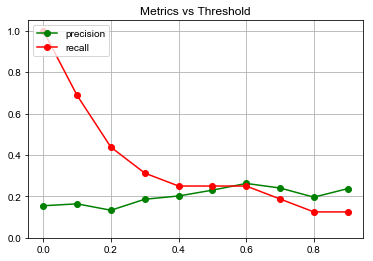

In [67]:
metrics_vs_threshold(model, X_test, test_labels, 'upper left')